## Basic Steps

1. Run a baseline training script to build a speech commands model.
2. Add in your custom word to the training and test/validation sets.
   - Modify labels, shape of your output tensor in the model.
   - Make sure that feature extractor for the model aligns with the feature extractor 
     used in the arduino code.
3. Re-train model. => TF Model using floating-point numbers, that recognizes Google word and custom word.
4. Quantize the model and convert to TFlite. => keyword_model.tflite file
5. Convert tflite to .c file, using xxd => model_data.cc
6. Replace contents of existing micro_features_model.cpp with output of xxd.

All of the above steps are done in this notebook for the commands 'left', 'right'.

7. In micro_speech.ino, modify micro_op_resolver (around line 80) to add any necessary operations (DIFF_FROM_LECTURE)
8. In micro_features_model_settings.h, modify kSilenceIndex and kUnknownIndex, depending on 
where you have them in commands.  
  - Commands = ['left', 'right', '_silence', '_unknown'] => kSilenceIndex=2, kUnknownIndex=3
9. In micro_features_model_settings.cpp, modify kCategoryLabels to correspond to commands in this script.
10. In micro_features_micro_model_settings.h, set kFeatureSliceDurationMs, kFeatureSliceStrideMs to match what is passed to microfrontend as window_size, window_step, respectively.
11. Rebuild Arduino program, run it, recognize the two target words.
12. Experiment with model architecture, training parameters/methods, augmentation, more data-gathering, etc.

*Note*:  As of 5/3/21, this model uses 22% of flash and 49.5% of RAM, so there is substantial space to improve the model, but the latency is about 208ms, which is probably too slow.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import Input, layers
from tensorflow.keras import models
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op
print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#from tqdm.notebook import tqdm
from tqdm import tqdm # replace with this if moving out of notebook

import os
import pathlib

from datetime import datetime as dt

from IPython import display

2.8.0


In [2]:
# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
i16min = -2**15
i16max = 2**15-1
fsamp = 16000
wave_length_ms = 1000
wave_length_samps = int(wave_length_ms*fsamp/1000)
window_size_ms=60
window_step_ms=40
num_filters = 32
use_microfrontend = True #used for microcontroller 
dataset = 'full-speech-files' # use the full speech commands stored as files 

silence_str = "_silence"  
unknown_str = "_unknown"
EPOCHS = 50

Apply the frontend to an example signal.

In [4]:
data_dir = pathlib.Path(os.path.join('/Users/Jeromey/IOT/Project1/data/speech_train'))

In [5]:
data_dir

WindowsPath('/Users/Jeromey/IOT/Project1/data/speech_train')

In [6]:
commands = ['armadillo', 'backward'] 
label_list = commands.copy()
label_list.insert(0, silence_str)
label_list.insert(1, unknown_str)
print('label_list:', label_list)

label_list: ['_silence', '_unknown', 'armadillo', 'backward']


In [7]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*.wav')
#filenames = tf.concat([tf.io.gfile.glob(str(data_dir) + '/' + cmd + '/*') for cmd in label_list], 0)
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
    len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 147619
Number of examples per label: 21816
Example file tensor: tf.Tensor(b'\\Users\\Jeromey\\IOT\\Project1\\data\\speech_train\\yes\\4b25f620_nohash_0.wav', shape=(), dtype=string)


In [8]:
filenames
# tf.strings.split(filenames[0], os.path.sep)[-2].numpy().decode('utf8')

<tf.Tensor: shape=(147619,), dtype=string, numpy=
array([b'\\Users\\Jeromey\\IOT\\Project1\\data\\speech_train\\yes\\4b25f620_nohash_0.wav',
       b'\\Users\\Jeromey\\IOT\\Project1\\data\\speech_train\\nine\\953fe1ad_nohash_2.wav',
       b'\\Users\\Jeromey\\IOT\\Project1\\data\\speech_train\\four\\674ca5ea_nohash_0.wav',
       ...,
       b'\\Users\\Jeromey\\IOT\\Project1\\data\\speech_train\\armadillo\\armadillo_Sample889_LShift2_0.wav',
       b'\\Users\\Jeromey\\IOT\\Project1\\data\\speech_train\\left\\0487ba9b_nohash_0.wav',
       b'\\Users\\Jeromey\\IOT\\Project1\\data\\speech_train\\yes\\63f7a489_nohash_1.wav'],
      dtype=object)>

In [9]:
# Not really necessary, but just look at a few of the files to make sure that 
# they're the correct files, shuffled, etc.
for i in range(10):
    print(filenames[i].numpy().decode('utf8'))

\Users\Jeromey\IOT\Project1\data\speech_train\yes\4b25f620_nohash_0.wav
\Users\Jeromey\IOT\Project1\data\speech_train\nine\953fe1ad_nohash_2.wav
\Users\Jeromey\IOT\Project1\data\speech_train\four\674ca5ea_nohash_0.wav
\Users\Jeromey\IOT\Project1\data\speech_train\armadillo\armadillo_Sample76_RShift3_0.wav
\Users\Jeromey\IOT\Project1\data\speech_train\armadillo\armadillo_Sample6150_Noise0_Multiplier1.wav
\Users\Jeromey\IOT\Project1\data\speech_train\no\6727b579_nohash_0.wav
\Users\Jeromey\IOT\Project1\data\speech_train\stop\bde0f20a_nohash_2.wav
\Users\Jeromey\IOT\Project1\data\speech_train\marvin\c1eebc0b_nohash_0.wav
\Users\Jeromey\IOT\Project1\data\speech_train\three\ceaadb24_nohash_0.wav
\Users\Jeromey\IOT\Project1\data\speech_train\backward\backward_Sample1318_LShift2_1.wav


In [10]:
fname_val_files = os.path.join(data_dir, 'validation_list.txt')    
with open(fname_val_files) as fpi_val:
    val_files = fpi_val.read().splitlines()
# validation_list.txt only lists partial paths
val_files = [os.path.join(data_dir, fn) for fn in val_files]
fname_test_files = os.path.join(data_dir, 'testing_list.txt')

with open(fname_test_files) as fpi_tst:
    test_files = fpi_tst.read().splitlines()
# testing_list.txt only lists partial paths
test_files = [os.path.join(data_dir, fn).rstrip() for fn in test_files]    

# convert the TF tensor filenames into an array of strings so we can use basic python constructs
train_files = [f.decode('utf8') for f in filenames.numpy()]


# don't train with the _background_noise_ files; exclude when directory name starts with '_'
train_files = [f for f in train_files if f.split('\\')[-2][0] != '_']

# validation and test files are listed explicitly in *_list.txt; train with everything else
train_files = list(set(train_files) - set(test_files) - set(val_files))
# now convert back into a TF tensor so we can use the tf.dataset pipeline
train_files = tf.constant(train_files)    


print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))


Training set size 126529
Validation set size 19981
Test set size 11149


In [11]:
fname_test_files

'\\Users\\Jeromey\\IOT\\Project1\\data\\speech_train\\testing_list.txt'

In [12]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [13]:
# @tf.function
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  in_set = tf.reduce_any(parts[-2] == label_list)
  label = tf.cond(in_set, lambda: parts[-2], lambda: tf.constant(unknown_str))
  # print(f"parts[-2] = {parts[-2]}, in_set = {in_set}, label = {label}")
  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return  label # parts[-2]

In [14]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [15]:
def get_spectrogram(waveform):
  # Concatenate audio with padding so that all audio clips will be of the 
  # same length (16000 samples)
  zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.int16)
  waveform = tf.cast(0.5*waveform*(i16max-i16min), tf.int16)  # scale float [-1,+1]=>INT16
  equal_length = tf.concat([waveform, zero_padding], 0)
  ## Make sure these labels correspond to those used in micro_features_micro_features_generator.cpp
  spectrogram = frontend_op.audio_microfrontend(equal_length, sample_rate=fsamp, num_channels=num_filters,
                                    window_size=window_size_ms, window_step=window_step_ms)
  return spectrogram


Function to convert each waveform in a set into a spectrogram, then convert those
back into a dataset using `from_tensor_slices`.  (We should be able to use 
`wav_ds.map(get_spectrogram_and_label_id)`, but there is a problem with that process).
   

In [16]:
def create_silence_dataset(num_waves, samples_per_wave, rms_noise_range=[0.01,0.2], silent_label=silence_str):
    # create num_waves waveforms of white gaussian noise, with rms level drawn from rms_noise_range
    # to act as the "silence" dataset
    rng = np.random.default_rng()
    rms_noise_levels = rng.uniform(low=rms_noise_range[0], high=rms_noise_range[1], size=num_waves)
    rand_waves = np.zeros((num_waves, samples_per_wave), dtype=np.float32) # pre-allocate memory
    for i in range(num_waves):
        rand_waves[i,:] = rms_noise_levels[i]*rng.standard_normal(samples_per_wave)
    labels = [silent_label]*num_waves
    return tf.data.Dataset.from_tensor_slices((rand_waves, labels))  

In [17]:
def wavds2specds(waveform_ds, verbose=True):
  wav, label = next(waveform_ds.as_numpy_iterator())
  one_spec = get_spectrogram(wav)
  one_spec = tf.expand_dims(one_spec, axis=0)  # add a 'batch' dimension at the front
  one_spec = tf.expand_dims(one_spec, axis=-1) # add a singleton 'channel' dimension at the back    

  num_waves = 0 # count the waveforms so we can allocate the memory
  for wav, label in waveform_ds:
    num_waves += 1
  print(f"About to create spectrograms from {num_waves} waves")
  spec_shape = (num_waves,) + one_spec.shape[1:] 
  spec_grams = np.nan * np.zeros(spec_shape)  # allocate memory
  labels = np.nan * np.zeros(num_waves)
  idx = 0
  for wav, label in waveform_ds:    
    if verbose and idx % 250 == 0:
      print(f"\r {idx} wavs processed", end='')
    spectrogram = get_spectrogram(wav)
    # TF conv layer expect inputs structured as 4D (batch_size, height, width, channels)
    # the microfrontend returns 2D tensors (freq, time), so we need to 
    spectrogram = tf.expand_dims(spectrogram, axis=0)  # add a 'batch' dimension at the front
    spectrogram = tf.expand_dims(spectrogram, axis=-1) # add a singleton 'channel' dimension at the back
    spec_grams[idx, ...] = spectrogram
    new_label = label.numpy().decode('utf8')
    new_label_id = np.argmax(new_label == np.array(label_list))    
    labels[idx] = new_label_id # for numeric labels
    # labels.append(new_label) # for string labels
    idx += 1
  labels = np.array(labels, dtype=int)
  output_ds = tf.data.Dataset.from_tensor_slices((spec_grams, labels))  
  return output_ds

In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
num_train_files = len(train_files)
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)


In [19]:
train_ds = wavds2specds(waveform_ds)

About to create spectrograms from 126529 waves
 126500 wavs processed

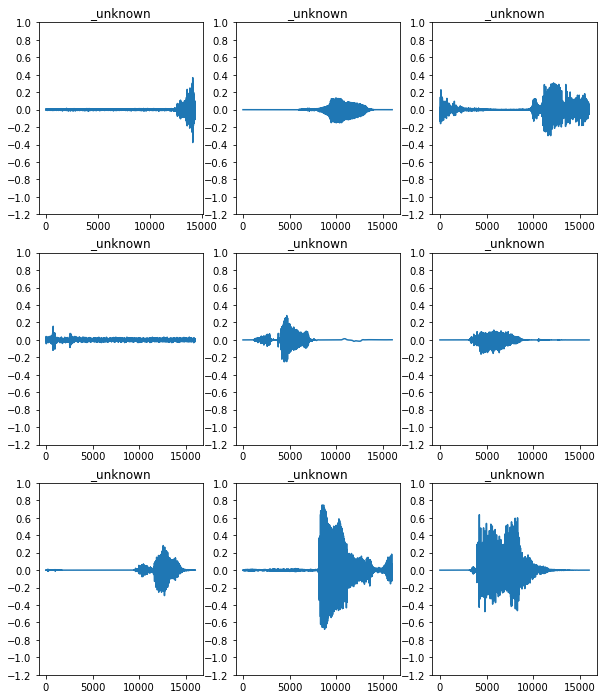

In [20]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [21]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: _unknown
Waveform shape: (14336,)
Spectrogram shape: (24, 32)
Audio playback


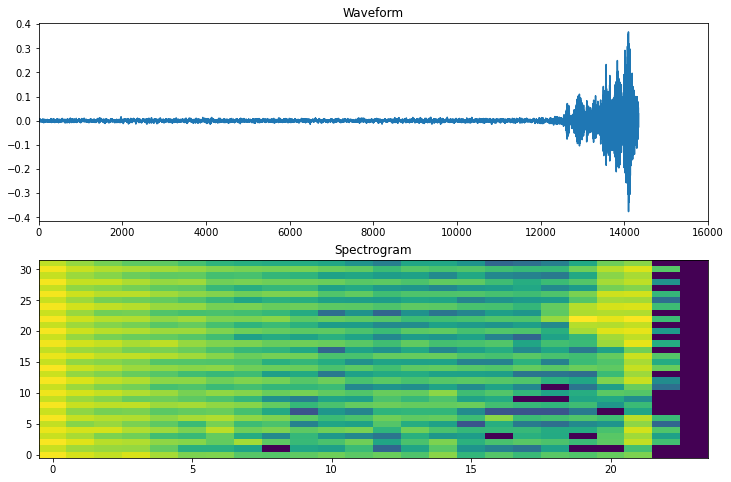

In [22]:
def plot_spectrogram(spectrogram, ax):
  # transpose so that the time is
  # represented in the x-axis (columns).
  freq_bins = spectrogram.shape[1]
  time_dur = spectrogram.shape[0]
  X = np.arange(time_dur)
  Y = range(freq_bins)
  ax.pcolormesh(X, Y, spectrogram.T)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [23]:
def count_labels(dataset):
    counts = {}
    for _, lbl in dataset:
        if lbl.dtype == tf.string:
            label = lbl.numpy().decode('utf-8')
        else:
            label = lbl.numpy()
        if label in counts:
            counts[label] += 1
        else:
            counts[label] = 1
    return counts

In [24]:
spectrogram.numpy().shape

(24, 32)

C:\Users\Jeromey\AppData\Local\Temp\ipykernel_20404\1859809011.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ax.set_title(label_list[np.int(label_id)])


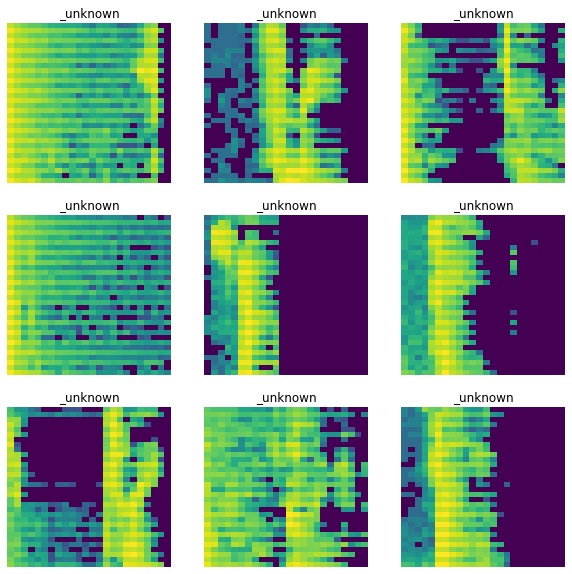

In [25]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(train_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(label_list[np.int(label_id)])
  ax.axis('off')

plt.show()

In [26]:
def copy_with_noise(ds_input, rms_level=0.25):
  rng = tf.random.Generator.from_seed(1234)
  wave_shape = tf.constant((wave_length_samps,))
  def add_noise(waveform, label):
    noise = rms_level*rng.normal(shape=wave_shape)
    zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.concat([waveform, zero_padding], 0)    
    noisy_wave = waveform + noise
    return noisy_wave, label

  return ds_input.map(add_noise)

In [27]:
# waveform_ds = augment_with_noise(waveform_ds)
count = 0
for w,l in waveform_ds:
  if w.shape != (16000,):
    print(f"element {count} has shape {w.shape}")
    break
  count += 1
print(count)

element 0 has shape (14336,)
0


In [28]:
def pad_16000(waveform, label):
    zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.concat([waveform, zero_padding], 0)        
    return waveform, label

In [29]:
# Collect what we did to generate the training dataset into a 
# function, so we can repeat with the validation and test sets.
def preprocess_dataset(files, num_silent=None, noisy_reps_of_known=None):
  # if noisy_reps_of_known is not None, it should be a list of rms noise levels
  # For every target word in the data set, 1 copy will be created with each level 
  # of noise added to it.  So [0.1, 0.2] will add 2x noisy copies of the target words 
  if num_silent is None:
    num_silent = int(0.2*len(files))+1
  print(f"Processing {len(files)} files")
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  waveform_ds = files_ds.map(get_waveform_and_label)
  if noisy_reps_of_known is not None:
    # create a few copies of only the target words to balance the distribution
    # create a tmp dataset with only the target words
    ds_only_cmds = waveform_ds.filter(lambda w,l: tf.reduce_any(l == commands))
    for noise_level in noisy_reps_of_known:
       waveform_ds = waveform_ds.concatenate(copy_with_noise(ds_only_cmds, rms_level=noise_level))
  if num_silent > 0:
    silent_wave_ds = create_silence_dataset(num_silent, wave_length_samps, 
                                            rms_noise_range=[0.01,0.2], 
                                            silent_label=silence_str)
    waveform_ds = waveform_ds.concatenate(silent_wave_ds)
  print(f"Added {num_silent} silent wavs and {noisy_reps_of_known} noisy wavs")
  num_waves = 0
  output_ds = wavds2specds(waveform_ds)
  return output_ds

In [30]:
print(f"We have {len(train_files)}/{len(val_files)}/{len(test_files)} training/validation/test files")

We have 126529/19981/11149 training/validation/test files


In [49]:
train_ds = preprocess_dataset(train_files,num_silent=85000, noisy_reps_of_known=[0.05,0.1,0.15,0.2,0.25])

Processing 126529 files
Added 85000 silent wavs and [0.05, 0.1, 0.15, 0.2, 0.25] noisy wavs
About to create spectrograms from 377549 waves
 377500 wavs processed

In [50]:
val_ds = preprocess_dataset(val_files)


Processing 19981 files
Added 3997 silent wavs and None noisy wavs
About to create spectrograms from 23978 waves
 23750 wavs processed

In [53]:
test_ds = preprocess_dataset(test_files)

Processing 11149 files
Added 2230 silent wavs and None noisy wavs
About to create spectrograms from 13379 waves
 13250 wavs processed

In [54]:
print("training data set")
print(count_labels(train_ds))
print("val_ds data set")
print(count_labels(val_ds))
print("test_ds data set")
print(count_labels(test_ds))

training data set
{1: 93325, 2: 100194, 3: 99030, 0: 85000}
val_ds data set
{1: 9981, 2: 5000, 3: 5000, 0: 3997}
test_ds data set
{1: 10840, 3: 165, 2: 144, 0: 2230}


In [55]:
train_ds = train_ds.shuffle(int(len(train_files)*1.2))
val_ds = val_ds.shuffle(int(len(val_files)*1.2))
test_ds = test_ds.shuffle(int(len(test_files)*1.2))

In [56]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [57]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [58]:
for spectrogram, _ in train_ds.take(1):
  spec1 = spectrogram
# take(1) takes 1 *batch*, so we have to select the first 
# spectrogram from it, hence the [0]
print(f"Spectrogram shape {spec1[0].shape}")
print(f"ranges from {np.min(spec1)} to {np.max(spec1)}")   # min/max across the whole batch

Spectrogram shape (24, 32, 1)
ranges from 0.0 to 713.0


In [59]:
for spectrogram, _ in train_ds.take(1):
  # take(1) takes 1 *batch*, so we have to select the first 
  # spectrogram from it, hence the [0]
  input_shape = spectrogram[0].shape  
print('Input shape:', input_shape)
num_labels = len(label_list)


Input shape: (24, 32, 1)


In [60]:
print('Input shape:', input_shape)

norm_layer = tf.keras.layers.Normalization(axis=-1)

model = models.Sequential([
    layers.Input(shape=input_shape),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(name='pool1'),
    layers.DepthwiseConv2D(kernel_size=(3,3), padding='same'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(name='pool2'),
    layers.DepthwiseConv2D(kernel_size=(3,3), padding='same'),
    layers.MaxPooling2D(name='pool3'),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_labels),
], name="simple_nn")

model.summary()


Input shape: (24, 32, 1)
Model: "simple_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 24, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 30, 32)        320       
                                                                 
 pool1 (MaxPooling2D)        (None, 11, 15, 32)        0         
                                                                 
 depthwise_conv2d_2 (Depthwi  (None, 11, 15, 32)       320       
 seConv2D)                                                       
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 13, 32)         9248      
                                                                 
 pool2 (MaxPooling2D)        (N

In [116]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [117]:
callback=tf.keras.callbacks.EarlyStopping(
    monitor= 'accuracy',
    verbose=1,
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    #epochs=EPOCHS
    epochs=5000, 
    callbacks=[callback]
)

Epoch 1/5000
5900/5900 [==============================] - 227s 38ms/step - loss: 0.2576 - accuracy: 0.9065 - val_loss: 0.1292 - val_accuracy: 0.9732
Epoch 2/5000
5900/5900 [==============================] - 227s 38ms/step - loss: 0.2238 - accuracy: 0.9191 - val_loss: 0.1281 - val_accuracy: 0.9749
Epoch 3/5000
5900/5900 [==============================] - 227s 38ms/step - loss: 0.2046 - accuracy: 0.9264 - val_loss: 0.1506 - val_accuracy: 0.9835
Epoch 4/5000
5900/5900 [==============================] - 225s 38ms/step - loss: 0.1907 - accuracy: 0.9314 - val_loss: 0.1524 - val_accuracy: 0.9837
Epoch 5/5000
5900/5900 [==============================] - 226s 38ms/step - loss: 0.1784 - accuracy: 0.9352 - val_loss: 0.1251 - val_accuracy: 0.9854
Epoch 6/5000
5900/5900 [==============================] - 224s 38ms/step - loss: 0.1667 - accuracy: 0.9396 - val_loss: 0.1711 - val_accuracy: 0.9859
Epoch 7/5000
5900/5900 [==============================] - 224s 38ms/step - loss: 0.1570 - accuracy: 0.9424

Epoch 108: early stopping


In [118]:
# number of MACs in each layer is (# outputs in layer) * (number of inputs that contribute to one output)
macs = np.array([(14*38*20)*(3*3), (7*19*20)*(3*3), (7*19*32)*20, 128*128, 128*128,128*128, 4*128])
print(macs)
print(np.sum(macs))

[95760 23940 85120 16384 16384 16384   512]
254484


In [119]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [122]:
date_str = dt.now().strftime("%d%b%Y_%H%M").lower()
model_file_name = f"kws_ufe_{date_str}.h5" 
print(f"Saving model to {model_file_name}")
model.save(model_file_name, overwrite=False)

Saving model to kws_ufe_24apr2022_0628.h5


In [123]:
with open(model_file_name.split('.')[0] + '.txt', 'w') as fpo:
    fpo.write(f"i16min            = {i16min           }\n")
    fpo.write(f"i16max            = {i16max           }\n")
    fpo.write(f"fsamp             = {fsamp            }\n")
    fpo.write(f"wave_length_ms    = {wave_length_ms   }\n")
    fpo.write(f"wave_length_samps = {wave_length_samps}\n")
    fpo.write(f"window_size_ms    = {window_size_ms   }\n")
    fpo.write(f"window_step_ms    = {window_step_ms   }\n")
    fpo.write(f"num_filters       = {num_filters      }\n")
    fpo.write(f"use_microfrontend = {use_microfrontend}\n")
    fpo.write(f"label_list        = {label_list}\n")
    fpo.write(f"spectrogram_shape = {spectrogram.numpy().shape}\n")


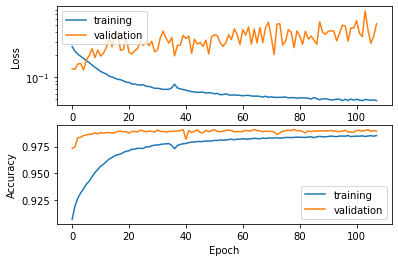

In [124]:
metrics = history.history
plt.subplot(2,1,1)
plt.semilogy(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.subplot(2,1,2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [125]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [126]:
test_labels

array([1, 1, 1, ..., 1, 1, 1])

In [127]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 99%


On test set:
Test set accuracy: 99%


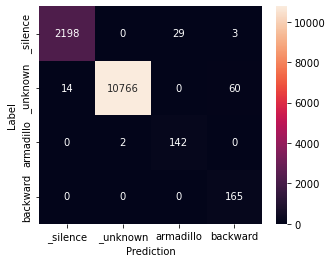

In [128]:

print("On test set:")
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
#plt.gca().invert_yaxis() # flip so origin is at bottom left
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

On test set:
Test set accuracy: 99%


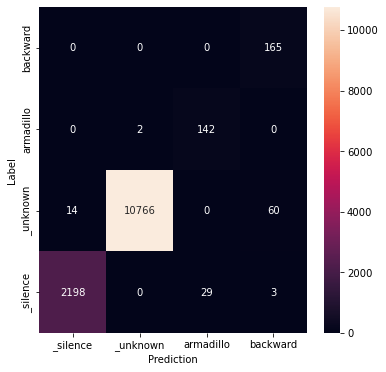

In [129]:

print("On test set:")
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.gca().invert_yaxis() # flip so origin is at bottom left
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

On validation set:
Data set accuracy: 99%


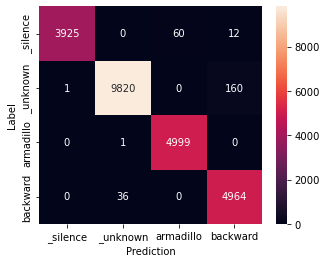

In [130]:
dset = val_ds.unbatch()
print("On validation set:")

ds_audio = []
ds_labels = []

for audio, label in dset:
  ds_audio.append(audio.numpy())
  ds_labels.append(label.numpy())

ds_labels = np.array(ds_labels)
ds_audio = np.array(ds_audio)

model_out = model.predict(ds_audio)
y_pred = np.argmax(model_out, axis=1)
y_true = ds_labels

ds_acc = sum(y_pred == y_true) / len(y_true)
print(f'Data set accuracy: {ds_acc:.0%}')

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(5,4))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

On training set:
Data set accuracy: 99%


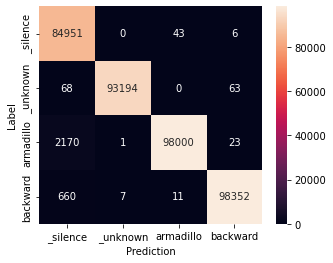

In [131]:
dset = train_ds.unbatch()
print("On training set:")

ds_audio = []
ds_labels = []

for audio, label in dset:
  ds_audio.append(audio.numpy())
  ds_labels.append(label.numpy())

ds_labels = np.array(ds_labels)
ds_audio = np.array(ds_audio)

model_out = model.predict(ds_audio)
y_pred = np.argmax(model_out, axis=1)
y_true = ds_labels

ds_acc = sum(y_pred == y_true) / len(y_true)
print(f'Data set accuracy: {ds_acc:.0%}')

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(5,4))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

Processing 4 files
Added 1 silent wavs and None noisy wavs
About to create spectrograms from 5 waves
 0 wavs processed

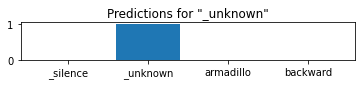

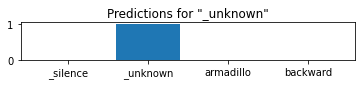

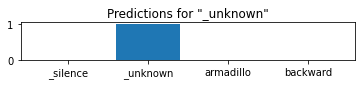

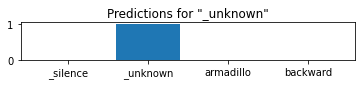

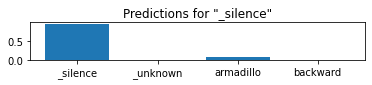

In [132]:
sample_files = [data_dir/'left/07ad9b59_nohash_0.wav', 
                data_dir/'no/01bb6a2a_nohash_0.wav',  
                data_dir/'right/0362539c_nohash_1.wav',
                data_dir/'right/b5d1e505_nohash_0.wav']
fstr_list = [str(f) for f in sample_files]
sample_ds = preprocess_dataset(fstr_list, num_silent=1)
count = 1
for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.subplot(len(sample_files)+1, 1, count)
  plt.bar(label_list, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{label_list[label[0]]}"')
  plt.show()
  count += 1

## Quantize and Convert to TFLite

In [133]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [134]:
num_calibration_steps = 10
ds_iter = val_ds.unbatch().batch(1).as_numpy_iterator()
def representative_dataset_gen():
  for _ in range(num_calibration_steps):
    next_input = next(ds_iter)[0]
    next_input = next_input.astype(np.float32)  # (DIFF_FROM_LECTURE)
    yield [next_input]

In [135]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8; should match dat_q in eval_quantized_model.py
converter.inference_output_type = tf.int8  # or tf.uint8

In [136]:
tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Jeromey\AppData\Local\Temp\tmpb4ytdptt\assets


INFO:tensorflow:Assets written to: C:\Users\Jeromey\AppData\Local\Temp\tmpb4ytdptt\assets
C:\Users\Jeromey\anaconda3\envs\IOT\lib\site-packages\tensorflow\lite\python\convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [137]:
fname = 'kws_model.tflite'
with open(fname, "wb") as fpo:
  num_bytes_written = fpo.write(tflite_quant_model)
print(f"Wrote {num_bytes_written} / {len(tflite_quant_model)} bytes to tflite file")

Wrote 521136 / 521136 bytes to tflite file


In [138]:
!xxd -i kws_model.tflite >! kws_model.cc

'xxd' is not recognized as an internal or external command,
operable program or batch file.
